In [5]:
import numpy as np
import pickle   
import matplotlib.pyplot as plt

In [4]:
with open('../ckpt/history_ckpt.pkl', 'rb') as f:
    history = pickle.load(f)

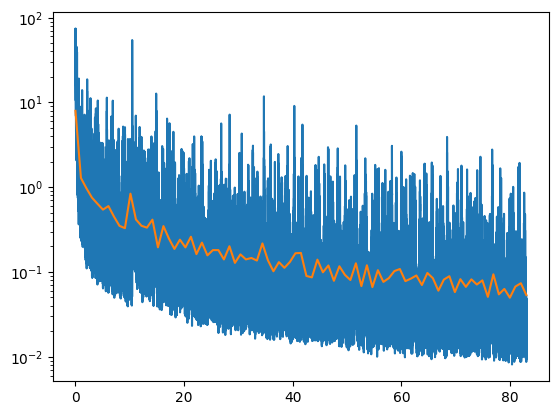

In [9]:
n_epochs = len(history['loss'])
plt.figure()
plt.plot(np.linspace(0, n_epochs, len(history['loss_iter'])), history['loss_iter'])
plt.plot(np.linspace(0, n_epochs, len(history['loss'])), history['loss'])
plt.yscale('log')

In [16]:
n_steps = 70000/1024*3000
n_steps

205078.125

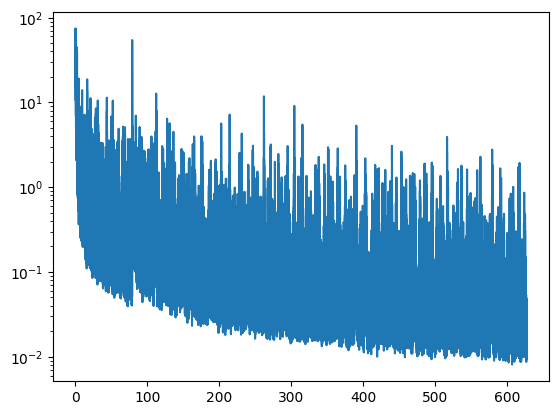

In [21]:
x = np.linspace(0, len(history['loss_iter']), len(history['loss_iter']))*len(history['loss_iter'])/n_steps/64

plt.figure()
plt.plot(x, history['loss_iter'])
plt.yscale('log')

In [22]:
history['loss']

[7.956833,
 1.2825211,
 0.9691094,
 0.7527884,
 0.63775384,
 0.5432874,
 0.5984317,
 0.45011953,
 0.35011017,
 0.3285027,
 0.8387698,
 0.41607678,
 0.35052928,
 0.333174,
 0.41413534,
 0.19519912,
 0.34759057,
 0.24741486,
 0.18681444,
 0.240281,
 0.19492719,
 0.2601126,
 0.16230802,
 0.22186399,
 0.15693519,
 0.18110311,
 0.18089108,
 0.14047818,
 0.20097911,
 0.12792265,
 0.16117819,
 0.14061578,
 0.14616156,
 0.13631321,
 0.21712509,
 0.13725889,
 0.10191528,
 0.13054955,
 0.111860365,
 0.13123623,
 0.16609266,
 0.16767778,
 0.08965711,
 0.086320706,
 0.13966578,
 0.09910374,
 0.119218275,
 0.07865405,
 0.116633005,
 0.09240001,
 0.080385335,
 0.12644005,
 0.06813425,
 0.11989601,
 0.066280544,
 0.10484948,
 0.07630826,
 0.08463026,
 0.102462314,
 0.10822191,
 0.07793068,
 0.08342707,
 0.090874255,
 0.07011148,
 0.097280614,
 0.08438967,
 0.06014684,
 0.081292935,
 0.08911033,
 0.057889372,
 0.08218059,
 0.06668233,
 0.081789695,
 0.07108418,
 0.07953325,
 0.05085324,
 0.09379714,
 